In [11]:
# %% [markdown]
# # Time-Invariant Diffeo AE vs TCDM Embeddings
#
# Loads:
# - cached TCDM embeddings + PCA frames from `tc_selected_embeddings.pkl`
# - trained time-invariant diffeomorphic autoencoder checkpoint
#
# Environment:
# - Intended to run in conda env `3MASB` (e.g. `conda run -n 3MASB python notebooks/time_invariant_diffeo_embedding_visualization.py`)
#
# Produces:
# - Multi-time grid (per-time panels) comparing TCDM vs AE-encoded embeddings
# - Single-panel overlay colored by time (time-invariant AE)

In [12]:
from __future__ import annotations

import sys
from pathlib import Path
import os
import json
import pickle

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec

import torch

def _repo_root() -> Path:
    try:
        return Path(__file__).resolve().parent.parent
    except NameError:  # pragma: no cover
        cwd = Path.cwd().resolve()
        return cwd.parent if cwd.name == "notebooks" else cwd


REPO_ROOT = _repo_root()
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from scripts.pca.pca_visualization_utils import _format_for_paper as format_for_paper  # noqa: E402
from mmsfm.ode_diffeo_ae_time_invariant import (  # noqa: E402
    TimeInvariantNeuralODEDiffeomorphismAutoencoder,
    ODESolverConfig,
)
from scripts.time_stratified_scaler import DistanceCurveScaler  # noqa: E402


def _torch_load(path: Path, *, weights_only: bool | None = None):
    """Load a torch checkpoint with sensible defaults for this repo.

    Notes:
        - `weights_only=True` is safest, but will fail for checkpoints that include
          non-tensor objects (e.g., numpy arrays in `scaler_state`).
        - If `weights_only` is None, we try `True` first then fall back to `False`.
        - Setting `weights_only=False` can execute arbitrary code if the checkpoint
          is untrusted; only do this for local/trusted artifacts.
    """
    try:
        if weights_only is None:
            try:
                return torch.load(path, map_location="cpu", weights_only=True)  # type: ignore[call-arg]
            except pickle.UnpicklingError:
                print(
                    f"WARNING: `{path}` is not compatible with weights-only loading; "
                    "retrying with `weights_only=False` (only safe for trusted checkpoints)."
                )
                return torch.load(path, map_location="cpu", weights_only=False)  # type: ignore[call-arg]
        return torch.load(path, map_location="cpu", weights_only=bool(weights_only))  # type: ignore[call-arg]
    except TypeError:
        # Older torch versions without `weights_only` kwarg.
        return torch.load(path, map_location="cpu")


def _encode_in_batches(
    model: TimeInvariantNeuralODEDiffeomorphismAutoencoder,
    x_np: np.ndarray,
    *,
    device: torch.device,
    batch_size: int = 256,
) -> np.ndarray:
    model.eval()
    x = torch.from_numpy(np.asarray(x_np, dtype=np.float32)).to(device=device)
    out: list[np.ndarray] = []
    with torch.inference_mode():
        for i in range(0, x.shape[0], int(batch_size)):
            y = model.encoder(x[i : i + int(batch_size)])
            out.append(y.detach().cpu().numpy())
    return np.concatenate(out, axis=0)


In [13]:
# %% [markdown]
# ## Paper Formatting

In [14]:
expected_conda_env = "3MASB"
active_conda_env = os.environ.get("CONDA_DEFAULT_ENV")
if active_conda_env is None:
    print(
        f"Note: CONDA_DEFAULT_ENV is not set. Intended environment is `{expected_conda_env}` "
        f"(sys.executable={sys.executable})."
    )
elif active_conda_env != expected_conda_env:
    print(
        f"WARNING: Active conda env is `{active_conda_env}`; intended `{expected_conda_env}` "
        f"(sys.executable={sys.executable})."
    )

format_for_paper()
print("✓ Applied paper formatting")

✓ Applied paper formatting


In [15]:
# %% [markdown]
# ## Paths

In [16]:
cache_path = (
    REPO_ROOT
    / "data/cache_pca_precomputed_unscaled_9999/tran_inclusions_unscaled_9999/tc_selected_embeddings.pkl"
)
best_ckpt_path = (
    REPO_ROOT / "results/2026-01-30T00-00-56-80/diffeo_autoencoder_best.pth"
)
full_ckpt_path = best_ckpt_path.with_name("diffeo_autoencoder.pth")
args_json_path = best_ckpt_path.with_name("args.json")

out_dir = REPO_ROOT / "figures"
out_dir.mkdir(parents=True, exist_ok=True)

print("cache_path:", cache_path)
print("best_ckpt_path:", best_ckpt_path)
print("full_ckpt_path:", full_ckpt_path)
print("args_json_path:", args_json_path)


cache_path: /data1/jy384/research/MMSFM/data/cache_pca_precomputed_unscaled_9999/tran_inclusions_unscaled_9999/tc_selected_embeddings.pkl
best_ckpt_path: /data1/jy384/research/MMSFM/results/2026-01-30T00-00-56-80/diffeo_autoencoder_best.pth
full_ckpt_path: /data1/jy384/research/MMSFM/results/2026-01-30T00-00-56-80/diffeo_autoencoder.pth
args_json_path: /data1/jy384/research/MMSFM/results/2026-01-30T00-00-56-80/args.json


In [17]:
# %% [markdown]
# ## Load Cached TCDM Embeddings + PCA Frames

In [18]:
with cache_path.open("rb") as f:
    cache_payload = pickle.load(f)

cache_data = cache_payload["data"]
selected_result = cache_data["selected_result"]

frames = np.asarray(cache_data.get("frames"), dtype=np.float32)  # (T, N, D_x)
embeddings_time_raw = np.asarray(selected_result["embeddings_time"], dtype=np.float32)  # (T, N, D_ref)
times = np.asarray(selected_result["times"], dtype=np.float32)
train_idx = np.asarray(cache_data["train_idx"], dtype=np.int64)

T, N, D_x = frames.shape
_, _, D_ref = embeddings_time_raw.shape
print(f"T={T}, N={N}, D_x={D_x}, D_ref={D_ref}")
print("times:", times)


T=5, N=5000, D_x=1386, D_ref=1280
times: [0.14285715 0.42857143 0.5714286  0.85714287 1.        ]


In [19]:
# %% [markdown]
# ## Load Checkpoint + Config + Scaler
#
# - Best checkpoint contains `state_dict`
# - Full checkpoint contains the fitted `scaler_state` (preferred)

In [20]:
best_ckpt = _torch_load(best_ckpt_path, weights_only=True)
best_state_dict = best_ckpt["state_dict"] if isinstance(best_ckpt, dict) else best_ckpt

config = None
scaler = None
if full_ckpt_path.exists():
    full_ckpt = _torch_load(full_ckpt_path, weights_only=False)
    config = full_ckpt.get("config")
    scaler_state = full_ckpt.get("scaler_state")
    if scaler_state is not None and scaler_state.get("type") == "distance_curve":
        scaler = DistanceCurveScaler.from_state_dict(scaler_state)

if config is None and args_json_path.exists():
    config = json.loads(args_json_path.read_text()).get("args")

if config is None:
    raise RuntimeError(
        "Could not find model config. Expected `diffeo_autoencoder.pth` (with config) "
        f"or `{args_json_path}`."
    )

latent_dim = int(config.get("latent_dim") or min(1024, D_ref))
ode_hidden = [int(v) for v in (config.get("ode_hidden") or [256, 256])]

solver = ODESolverConfig(
    method=str(config.get("ode_method", "dopri5")),
    rtol=float(config.get("ode_rtol", 1e-5)),
    atol=float(config.get("ode_atol", 1e-5)),
    use_adjoint=not bool(config.get("ode_no_adjoint", False)),
    adjoint_rtol=config.get("ode_adjoint_rtol", None),
    adjoint_atol=config.get("ode_adjoint_atol", None),
    step_size=config.get("ode_step_size", None),
    max_num_steps=config.get("ode_max_num_steps", None),
)

print("Model config:")
print("  ambient_dim:", D_x)
print("  latent_dim:", latent_dim)
print("  ode_hidden:", ode_hidden)
print("  solver:", solver)
print("  scaler:", "loaded" if scaler is not None else "None (will fit from cache train split)")


Model config:
  ambient_dim: 1386
  latent_dim: 1024
  ode_hidden: [1500, 1500]
  solver: ODESolverConfig(method='dopri5', rtol=1e-05, atol=1e-05, use_adjoint=True, adjoint_rtol=None, adjoint_atol=None, step_size=None, max_num_steps=None)
  scaler: loaded


In [21]:
# %% [markdown]
# ## Scale Reference (TCDM) Embeddings (Match Training Targets)

In [22]:
if scaler is None:
    # Re-fit scaler exactly like the training script (uses dummy monotone time grid).
    contraction_power = float(config.get("contraction_power", 1.0))
    target_std = float(config.get("target_std", 1.0))
    distance_curve_pairs = int(config.get("distance_curve_pairs", 4096))
    seed = int(config.get("seed", 42))

    latent_train_raw = np.asarray(cache_data["latent_train"], dtype=np.float32)
    if latent_train_raw.shape[1] != train_idx.shape[0]:
        raise RuntimeError(
            "Cache train split mismatch: latent_train does not match train_idx length."
        )

    t_dummy = np.linspace(0.0, 1.0, T, dtype=np.float64)
    scaler = DistanceCurveScaler(
        target_std=target_std,
        contraction_power=contraction_power,
        center_data=True,
        n_pairs=distance_curve_pairs,
        seed=seed,
    )
    scaler.fit(latent_train_raw, t_dummy)

t_dummy = np.linspace(0.0, 1.0, T, dtype=np.float64)
embeddings_time = np.asarray(
    scaler.transform_at_times(embeddings_time_raw, t_dummy), dtype=np.float32
)
embeddings_time = embeddings_time[:, :, :latent_dim]
print("Scaled embeddings_time:", embeddings_time.shape)


Scaled embeddings_time: (5, 5000, 1024)


In [23]:
# %% [markdown]
# ## Load Model + Encode PCA Frames

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

model = TimeInvariantNeuralODEDiffeomorphismAutoencoder(
    ambient_dim=int(D_x),
    latent_dim=int(latent_dim),
    vector_field_hidden=list(ode_hidden),
    solver=solver,
    mu=None,  # overwritten by checkpoint buffer
).to(device=device)
model.load_state_dict(best_state_dict, strict=True)
model.eval()
print("✓ Loaded AE weights")


device: cuda
✓ Loaded AE weights


In [25]:
# %% [markdown]
# ## Plot: Multi-Time Panel (TCDM vs AE Encoding)

/tmp/ipykernel_2957355/1192094969.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


Saved: /data1/jy384/research/MMSFM/figures/tcdm_vs_time_invariant_diffeo_ae_3d_timegrid.png


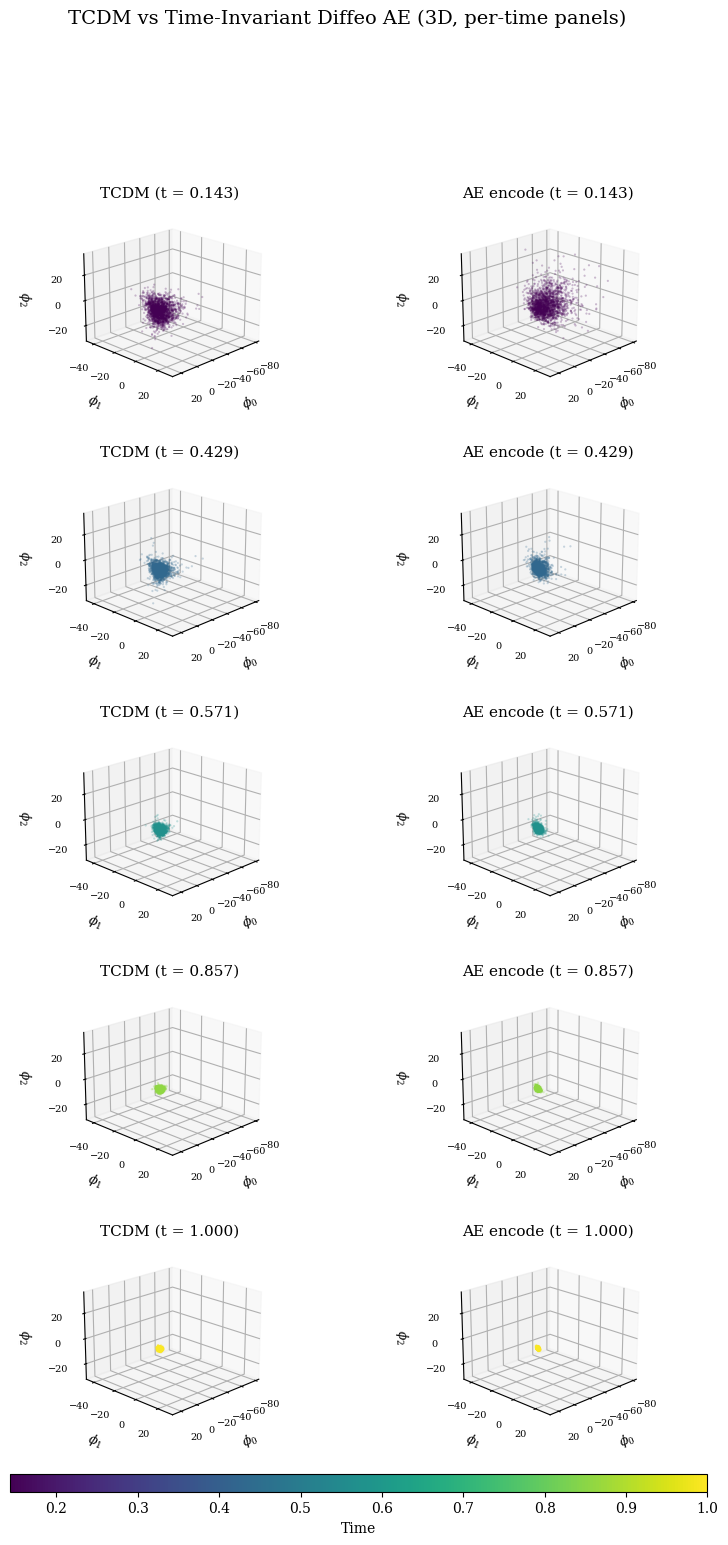

In [26]:
def plot_compare_embeddings_3d(
    *,
    embeddings_ref: np.ndarray,  # (T, N, K)
    frames_x: np.ndarray,  # (T, N, D)
    times: np.ndarray,  # (T,)
    model: TimeInvariantNeuralODEDiffeomorphismAutoencoder,
    dims: tuple[int, int, int] = (0, 1, 2),
    n_samples: int = 2000,
    seed: int = 42,
    alpha: float = 0.25,
    s: float = 2.5,
    encode_batch_size: int = 256,
    view_elev: float = 20.0,
    view_azim: float = 45.0,
    save_path: Path | None = None,
):
    T, N, K = embeddings_ref.shape
    if max(dims) >= K:
        raise ValueError(f"dims={dims} out of range for K={K}")

    rng = np.random.default_rng(int(seed))
    n_take = min(int(n_samples), int(N))
    sample_idx = [rng.choice(N, size=n_take, replace=False) for _ in range(T)]

    ref_pts = []
    ae_pts = []
    for t in range(T):
        idx = sample_idx[t]
        ref_pts.append(embeddings_ref[t, idx][:, list(dims)])
        ae_t = _encode_in_batches(
            model,
            frames_x[t, idx],
            device=next(model.parameters()).device,
            batch_size=int(encode_batch_size),
        )
        ae_pts.append(ae_t[:, list(dims)])

    ref_all = np.concatenate(ref_pts, axis=0)
    ae_all = np.concatenate(ae_pts, axis=0)
    all_pts = np.concatenate([ref_all, ae_all], axis=0)
    mins = all_pts.min(axis=0)
    maxs = all_pts.max(axis=0)
    margin = (maxs - mins) * 0.08

    fig = plt.figure(figsize=(9.0, 3.4 * T))
    gs = GridSpec(T, 2, figure=fig, hspace=0.35, wspace=0.18)

    cmap = cm.get_cmap("viridis")
    norm = plt.Normalize(vmin=float(times.min()), vmax=float(times.max()))

    for t in range(T):
        t_val = float(times[t])
        color = cmap(norm(t_val))

        ax0 = fig.add_subplot(gs[t, 0], projection="3d")
        ax1 = fig.add_subplot(gs[t, 1], projection="3d")

        ax0.scatter(
            ref_pts[t][:, 0],
            ref_pts[t][:, 1],
            ref_pts[t][:, 2],
            c=[color],
            alpha=float(alpha),
            s=float(s),
            edgecolors="none",
        )
        ax1.scatter(
            ae_pts[t][:, 0],
            ae_pts[t][:, 1],
            ae_pts[t][:, 2],
            c=[color],
            alpha=float(alpha),
            s=float(s),
            edgecolors="none",
        )

        for ax in (ax0, ax1):
            ax.set_xlim(mins[0] - margin[0], maxs[0] + margin[0])
            ax.set_ylim(mins[1] - margin[1], maxs[1] + margin[1])
            ax.set_zlim(mins[2] - margin[2], maxs[2] + margin[2])
            ax.set_xlabel(f"$\\phi_{{{dims[0]}}}$", fontsize=9)
            ax.set_ylabel(f"$\\phi_{{{dims[1]}}}$", fontsize=9)
            ax.set_zlabel(f"$\\phi_{{{dims[2]}}}$", fontsize=9)
            ax.view_init(elev=float(view_elev), azim=float(view_azim))
            ax.tick_params(labelsize=7)

        ax0.set_title(f"TCDM (t = {t_val:.3f})", fontsize=11)
        ax1.set_title(f"AE encode (t = {t_val:.3f})", fontsize=11)

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(
        sm, ax=fig.get_axes(), orientation="horizontal", fraction=0.03, pad=0.03, aspect=40
    )
    cbar.set_label("Time", fontsize=10)
    fig.suptitle("TCDM vs Time-Invariant Diffeo AE (3D, per-time panels)", fontsize=14, y=0.995)

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
        print("Saved:", save_path)

    return fig


fig = plot_compare_embeddings_3d(
    embeddings_ref=embeddings_time,
    frames_x=frames,
    times=times,
    model=model,
    dims=(0, 1, 2),
    n_samples=2000,
    encode_batch_size=256,
    save_path=out_dir / "tcdm_vs_time_invariant_diffeo_ae_3d_timegrid.png",
)
plt.show()


In [27]:
# %% [markdown]
# ## Plot: Single Panel (Overlay) Colored by Time

/tmp/ipykernel_2957355/1506973772.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


Saved: /data1/jy384/research/MMSFM/figures/tcdm_vs_time_invariant_diffeo_ae_overlay_timecolored_2d.png


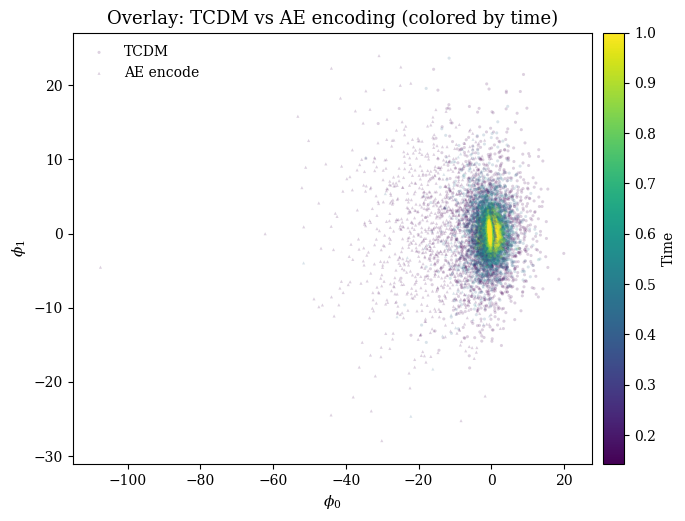

In [28]:
def plot_overlay_time_colored_2d(
    *,
    embeddings_ref: np.ndarray,  # (T, N, K)
    frames_x: np.ndarray,  # (T, N, D)
    times: np.ndarray,  # (T,)
    model: TimeInvariantNeuralODEDiffeomorphismAutoencoder,
    dims: tuple[int, int] = (0, 1),
    n_samples_per_time: int = 1000,
    seed: int = 42,
    alpha: float = 0.18,
    s: float = 5.0,
    encode_batch_size: int = 256,
    save_path: Path | None = None,
):
    T, N, K = embeddings_ref.shape
    if max(dims) >= K:
        raise ValueError(f"dims={dims} out of range for K={K}")

    rng = np.random.default_rng(int(seed))
    n_take = min(int(n_samples_per_time), int(N))

    ref_pts = []
    ae_pts = []
    t_vals = []
    for t in range(T):
        idx = rng.choice(N, size=n_take, replace=False)
        ref_t = embeddings_ref[t, idx][:, list(dims)]
        ae_t = _encode_in_batches(
            model,
            frames_x[t, idx],
            device=next(model.parameters()).device,
            batch_size=int(encode_batch_size),
        )[:, list(dims)]
        ref_pts.append(ref_t)
        ae_pts.append(ae_t)
        t_vals.append(np.full((n_take,), float(times[t]), dtype=np.float32))

    ref_all = np.concatenate(ref_pts, axis=0)
    ae_all = np.concatenate(ae_pts, axis=0)
    t_all = np.concatenate(t_vals, axis=0)

    all_pts = np.concatenate([ref_all, ae_all], axis=0)
    mins = all_pts.min(axis=0)
    maxs = all_pts.max(axis=0)
    margin = (maxs - mins) * 0.06

    cmap = cm.get_cmap("viridis")
    norm = plt.Normalize(vmin=float(times.min()), vmax=float(times.max()))

    fig, ax = plt.subplots(figsize=(7.2, 5.6))
    ax.scatter(
        ref_all[:, 0],
        ref_all[:, 1],
        c=t_all,
        cmap=cmap,
        norm=norm,
        marker="o",
        alpha=float(alpha),
        s=float(s),
        linewidths=0.0,
        label="TCDM",
    )
    ax.scatter(
        ae_all[:, 0],
        ae_all[:, 1],
        c=t_all,
        cmap=cmap,
        norm=norm,
        marker="^",
        alpha=float(alpha),
        s=float(s),
        linewidths=0.0,
        label="AE encode",
    )

    ax.set_xlim(mins[0] - margin[0], maxs[0] + margin[0])
    ax.set_ylim(mins[1] - margin[1], maxs[1] + margin[1])
    ax.set_xlabel(f"$\\phi_{{{dims[0]}}}$", fontsize=11)
    ax.set_ylabel(f"$\\phi_{{{dims[1]}}}$", fontsize=11)
    ax.set_title("Overlay: TCDM vs AE encoding (colored by time)", fontsize=13)
    ax.legend(frameon=False, fontsize=10, loc="best")

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.05, pad=0.02)
    cbar.set_label("Time", fontsize=10)

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
        print("Saved:", save_path)

    return fig


fig = plot_overlay_time_colored_2d(
    embeddings_ref=embeddings_time,
    frames_x=frames,
    times=times,
    model=model,
    dims=(0, 1),
    n_samples_per_time=1500,
    encode_batch_size=256,
    save_path=out_dir / "tcdm_vs_time_invariant_diffeo_ae_overlay_timecolored_2d.png",
)
plt.show()


## PCA Projection of Embeddings

/tmp/ipykernel_2957355/229854790.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


Saved: /data1/jy384/research/MMSFM/figures/tcdm_vs_ae_pca_3d.png


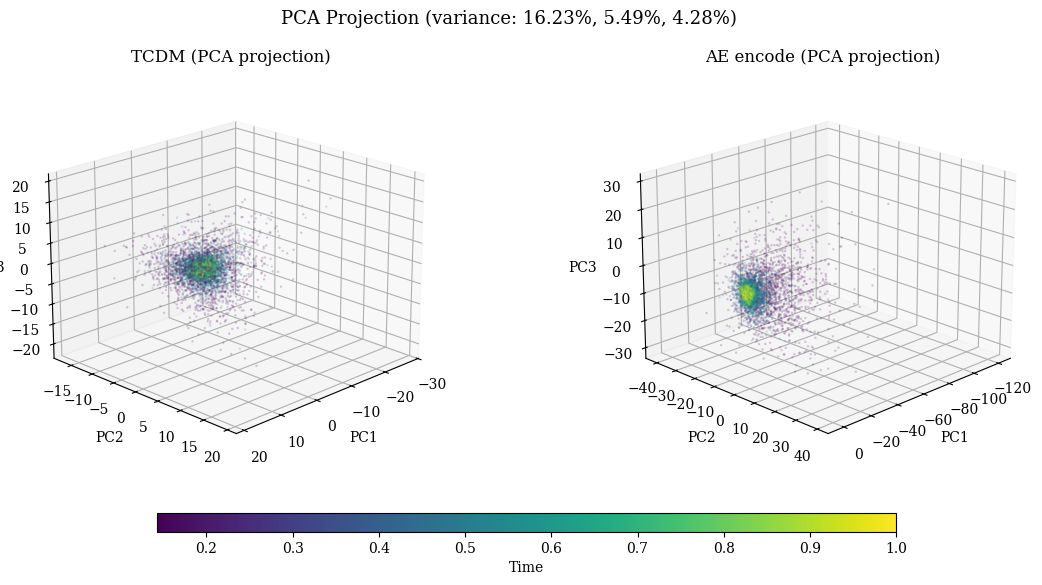

In [29]:
from sklearn.decomposition import PCA

def plot_pca_embeddings_3d(
    *,
    embeddings_ref: np.ndarray,
    frames_x: np.ndarray,
    times: np.ndarray,
    model: TimeInvariantNeuralODEDiffeomorphismAutoencoder,
    n_samples_per_time: int = 1000,
    seed: int = 42,
    alpha: float = 0.2,
    s: float = 3.0,
    encode_batch_size: int = 256,
    view_elev: float = 20.0,
    view_azim: float = 45.0,
    save_path: Path | None = None,
):
    """PCA projection of embeddings to 3D."""
    T, N, K = embeddings_ref.shape
    rng = np.random.default_rng(int(seed))
    n_take = min(int(n_samples_per_time), int(N))

    ref_pts = []
    ae_pts = []
    t_vals = []
    for t in range(T):
        idx = rng.choice(N, size=n_take, replace=False)
        ref_pts.append(embeddings_ref[t, idx])
        ae_t = _encode_in_batches(
            model,
            frames_x[t, idx],
            device=next(model.parameters()).device,
            batch_size=int(encode_batch_size),
        )
        ae_pts.append(ae_t)
        t_vals.append(np.full((n_take,), float(times[t]), dtype=np.float32))

    ref_all = np.concatenate(ref_pts, axis=0)
    ae_all = np.concatenate(ae_pts, axis=0)
    t_all = np.concatenate(t_vals, axis=0)

    all_data = np.concatenate([ref_all, ae_all], axis=0)
    pca = PCA(n_components=3)
    pca_all = pca.fit_transform(all_data)
    
    split_idx = ref_all.shape[0]
    pca_ref = pca_all[:split_idx]
    pca_ae = pca_all[split_idx:]

    cmap = cm.get_cmap("viridis")
    norm = plt.Normalize(vmin=float(times.min()), vmax=float(times.max()))

    fig = plt.figure(figsize=(14, 6))
    ax0 = fig.add_subplot(121, projection="3d")
    ax1 = fig.add_subplot(122, projection="3d")

    ax0.scatter(
        pca_ref[:, 0], pca_ref[:, 1], pca_ref[:, 2],
        c=t_all, cmap=cmap, norm=norm, alpha=float(alpha),
        s=float(s), edgecolors="none",
    )
    ax1.scatter(
        pca_ae[:, 0], pca_ae[:, 1], pca_ae[:, 2],
        c=t_all, cmap=cmap, norm=norm, alpha=float(alpha),
        s=float(s), edgecolors="none",
    )

    for ax, title in [(ax0, "TCDM"), (ax1, "AE encode")]:
        ax.set_xlabel("PC1", fontsize=10)
        ax.set_ylabel("PC2", fontsize=10)
        ax.set_zlabel("PC3", fontsize=10)
        ax.set_title(f"{title} (PCA projection)", fontsize=12)
        ax.view_init(elev=float(view_elev), azim=float(view_azim))

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=[ax0, ax1], orientation="horizontal", fraction=0.04, pad=0.08, aspect=40)
    cbar.set_label("Time", fontsize=10)

    var_explained = pca.explained_variance_ratio_
    fig.suptitle(
        f"PCA Projection (variance: {var_explained[0]:.2%}, {var_explained[1]:.2%}, {var_explained[2]:.2%})",
        fontsize=13,
    )

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
        print("Saved:", save_path)

    return fig


fig = plot_pca_embeddings_3d(
    embeddings_ref=embeddings_time,
    frames_x=frames,
    times=times,
    model=model,
    n_samples_per_time=1500,
    encode_batch_size=256,
    save_path=out_dir / "tcdm_vs_ae_pca_3d.png",
)
plt.show()

## Separate Overlay Plots (TCDM and AE)

/tmp/ipykernel_2957355/744359710.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


Saved: /data1/jy384/research/MMSFM/figures/tcdm_overlay_timecolored_2d.png
Saved: /data1/jy384/research/MMSFM/figures/ae_overlay_timecolored_2d.png


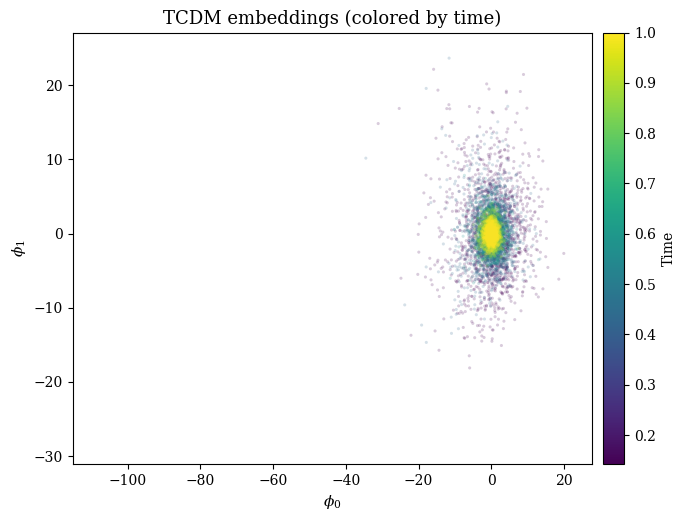

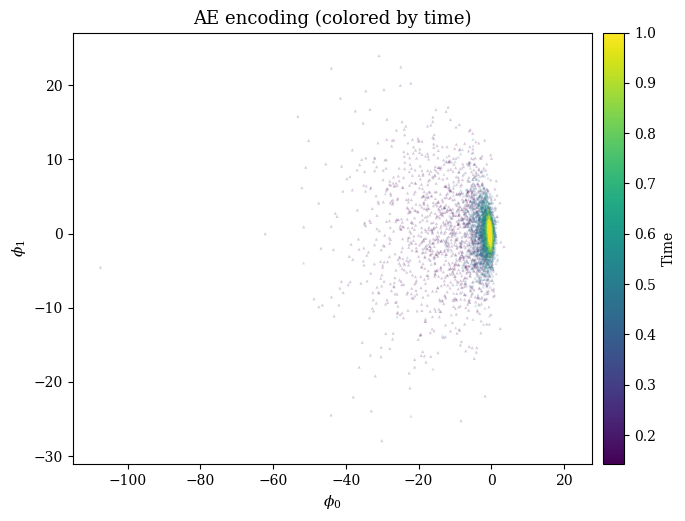

In [30]:
def plot_separate_overlays_2d(
    *,
    embeddings_ref: np.ndarray,
    frames_x: np.ndarray,
    times: np.ndarray,
    model: TimeInvariantNeuralODEDiffeomorphismAutoencoder,
    dims: tuple[int, int] = (0, 1),
    n_samples_per_time: int = 1000,
    seed: int = 42,
    alpha: float = 0.2,
    s: float = 5.0,
    encode_batch_size: int = 256,
    save_path_tcdm: Path | None = None,
    save_path_ae: Path | None = None,
):
    """Plot TCDM and AE embeddings separately, colored by time."""
    T, N, K = embeddings_ref.shape
    if max(dims) >= K:
        raise ValueError(f"dims={dims} out of range for K={K}")

    rng = np.random.default_rng(int(seed))
    n_take = min(int(n_samples_per_time), int(N))

    ref_pts = []
    ae_pts = []
    t_vals = []
    for t in range(T):
        idx = rng.choice(N, size=n_take, replace=False)
        ref_t = embeddings_ref[t, idx][:, list(dims)]
        ae_t = _encode_in_batches(
            model,
            frames_x[t, idx],
            device=next(model.parameters()).device,
            batch_size=int(encode_batch_size),
        )[:, list(dims)]
        ref_pts.append(ref_t)
        ae_pts.append(ae_t)
        t_vals.append(np.full((n_take,), float(times[t]), dtype=np.float32))

    ref_all = np.concatenate(ref_pts, axis=0)
    ae_all = np.concatenate(ae_pts, axis=0)
    t_all = np.concatenate(t_vals, axis=0)

    all_pts = np.concatenate([ref_all, ae_all], axis=0)
    mins = all_pts.min(axis=0)
    maxs = all_pts.max(axis=0)
    margin = (maxs - mins) * 0.06

    cmap = cm.get_cmap("viridis")
    norm = plt.Normalize(vmin=float(times.min()), vmax=float(times.max()))

    # TCDM plot
    fig1, ax1 = plt.subplots(figsize=(7.2, 5.6))
    ax1.scatter(
        ref_all[:, 0], ref_all[:, 1],
        c=t_all, cmap=cmap, norm=norm, marker="o",
        alpha=float(alpha), s=float(s), linewidths=0.0,
    )
    ax1.set_xlim(mins[0] - margin[0], maxs[0] + margin[0])
    ax1.set_ylim(mins[1] - margin[1], maxs[1] + margin[1])
    ax1.set_xlabel(f"$\\phi_{{{dims[0]}}}$", fontsize=11)
    ax1.set_ylabel(f"$\\phi_{{{dims[1]}}}$", fontsize=11)
    ax1.set_title("TCDM embeddings (colored by time)", fontsize=13)
    
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar1 = fig1.colorbar(sm, ax=ax1, orientation="vertical", fraction=0.05, pad=0.02)
    cbar1.set_label("Time", fontsize=10)

    if save_path_tcdm is not None:
        save_path_tcdm = Path(save_path_tcdm)
        save_path_tcdm.parent.mkdir(parents=True, exist_ok=True)
        fig1.savefig(save_path_tcdm, dpi=150, bbox_inches="tight")
        print("Saved:", save_path_tcdm)

    # AE plot
    fig2, ax2 = plt.subplots(figsize=(7.2, 5.6))
    ax2.scatter(
        ae_all[:, 0], ae_all[:, 1],
        c=t_all, cmap=cmap, norm=norm, marker="^",
        alpha=float(alpha), s=float(s), linewidths=0.0,
    )
    ax2.set_xlim(mins[0] - margin[0], maxs[0] + margin[0])
    ax2.set_ylim(mins[1] - margin[1], maxs[1] + margin[1])
    ax2.set_xlabel(f"$\\phi_{{{dims[0]}}}$", fontsize=11)
    ax2.set_ylabel(f"$\\phi_{{{dims[1]}}}$", fontsize=11)
    ax2.set_title("AE encoding (colored by time)", fontsize=13)
    
    cbar2 = fig2.colorbar(sm, ax=ax2, orientation="vertical", fraction=0.05, pad=0.02)
    cbar2.set_label("Time", fontsize=10)

    if save_path_ae is not None:
        save_path_ae = Path(save_path_ae)
        save_path_ae.parent.mkdir(parents=True, exist_ok=True)
        fig2.savefig(save_path_ae, dpi=150, bbox_inches="tight")
        print("Saved:", save_path_ae)

    return fig1, fig2


fig_tcdm, fig_ae = plot_separate_overlays_2d(
    embeddings_ref=embeddings_time,
    frames_x=frames,
    times=times,
    model=model,
    dims=(0, 1),
    n_samples_per_time=1500,
    encode_batch_size=256,
    save_path_tcdm=out_dir / "tcdm_overlay_timecolored_2d.png",
    save_path_ae=out_dir / "ae_overlay_timecolored_2d.png",
)
plt.show()